# Setup: Package Installation & Runtime Sanity Checks

This cell installs all required Python packages and performs basic runtime setup for the project. Specifically, it:

- Installs key libraries: `torch`, `torchvision`, `einops`, `kaggle`, `tensorboard`, and `grad-cam`
- Prints the PyTorch version and verifies if CUDA (GPU acceleration) is available
- Sets fixed random seeds (`torch`, `numpy`, `random`) for reproducibility
- Initializes a working data directory at `./data`, which will be used to store datasets like CIFAR-10

> Note: We are proceeding without ImageNet due to access restrictions and storage limitations.


In [1]:
# 🟢 Cell 0 — Package install & runtime sanity check

# Install required packages silently
%pip install --quiet torch torchvision einops kaggle tensorboard grad-cam torchinfo

# Imports
import torch
import torch.nn as nn
import os
import random
import numpy as np
from pathlib import Path
import platform
from torchinfo import summary

# Print PyTorch version and CUDA availability
print(f"PyTorch: {torch.__version__} | CUDA available? -> {torch.cuda.is_available()}")

# Set random seeds for reproducibility
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Enable cuDNN benchmark if input sizes are constant (e.g., for CIFAR-10)
torch.backends.cudnn.benchmark = True

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data root path for datasets
DATA_ROOT = Path("./data")
DATA_ROOT.mkdir(exist_ok=True)
print("DATA_ROOT set to", DATA_ROOT.resolve())

# Environment info summary
print(f"Python: {platform.python_version()} | NumPy: {np.__version__}")


Note: you may need to restart the kernel to use updated packages.
PyTorch: 2.7.0+cpu | CUDA available? -> False
Using device: cpu
DATA_ROOT set to C:\Users\LabUser\Desktop\CS4782_Final_Project\data
Python: 3.9.13 | NumPy: 1.21.5


In [2]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA available: False
Device name: No GPU detected


In [3]:
!nvidia-smi


Mon May 12 14:21:55 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.18                 Driver Version: 531.18       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000              WDDM | 00000000:07:00.0  On |                  Off |
| 30%   45C    P8               31W / 300W|   1394MiB / 49140MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 🟢 EfficientNet-B0: Baseline Model Architecture

This cell defines the **EfficientNet-B0** architecture, **without compound scaling** (i.e., `ϕ = 0`), as a baseline model.

### Key Components:

- **`ConvBNAct`**: Convolution + BatchNorm + Swish (SiLU) activation.
- **`SqueezeExcite`**: Channel-wise attention via squeeze-and-excitation.
- **`StochDepth`**: Stochastic depth (drop connect) for regularization.
- **MBConv Block**: Core Mobile Inverted Bottleneck Convolution block.
- **BASE Blueprint**: Configuration of each stage (repeats, kernel size, stride, expansion factor, output channels) as described in the EfficientNet paper.

- **`efficientnet_b0()`**: Factory function that:
  - Constructs the model with MBConv blocks and a classification head.
  - Applies stochastic depth and Squeeze-and-Excite for regularization and attention.

### Model Construction & Sanity Check:

- Defines the architecture using the `efficientnet_b0()` function.
- Includes a final head: 1x1 convolution → global average pooling → dropout → linear classifier.
- Runs `torchinfo.summary()` to print a detailed architecture summary.

### Output:
The summary includes the layer-by-layer breakdown of the model with input size `(1, 3, 224, 224)`.


In [4]:
# ------------------------------------------------------------------ #
# Helper Layers                                                      #
# ------------------------------------------------------------------ #

class ConvBNAct(nn.Sequential):
    def __init__(self, c_in, c_out, k, s=1, p=None, g=1):
        p = k // 2 if p is None else p
        super().__init__(
            nn.Conv2d(c_in, c_out, k, s, p, groups=g, bias=False),
            nn.BatchNorm2d(c_out),
            nn.SiLU(inplace=True)
        )

class SqueezeExcite(nn.Module):
    def __init__(self, channels, ratio=0.25):
        super().__init__()
        hidden = max(1, int(channels * ratio))
        self.net = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, hidden, 1),
            nn.SiLU(inplace=True),
            nn.Conv2d(hidden, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.net(x)

class StochDepth(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training or self.p == 0.0:
            return x
        keep = torch.rand((x.size(0), 1, 1, 1), device=x.device) > self.p
        return x.div(1 - self.p) * keep

class MBConv(nn.Module):
    def __init__(self, c_in, c_out, expand, k, s, drop):
        super().__init__()
        self.use_res = (s == 1 and c_in == c_out)
        self.drop = StochDepth(drop)

        hidden = c_in * expand
        layers = []
        if expand != 1:
            layers.append(ConvBNAct(c_in, hidden, 1))
        layers += [
            ConvBNAct(hidden, hidden, k, s, g=hidden),
            SqueezeExcite(hidden),
            nn.Conv2d(hidden, c_out, 1, bias=False),
            nn.BatchNorm2d(c_out),
        ]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        y = self.block(x)
        return x + self.drop(y) if self.use_res else y

# ------------------------------------------------------------------ #
# EfficientNet-B0 BASE config (scaled)                               #
# ------------------------------------------------------------------ #

BASE = [
    (1, 3, 1, 1,  16),
    (2, 3, 2, 6,  24),
    (2, 5, 2, 6,  40),
    (3, 3, 2, 6,  80),
    (3, 5, 1, 6, 112),
    (4, 5, 2, 6, 192),
    (1, 3, 1, 6, 320),
]



In [5]:
# ------------------------------------------------------------------ #
# EfficientNet-B0 Model                                              #
# ------------------------------------------------------------------ #

def efficientnet_b0(num_classes=10, drop_rate=0.2, drop_connect=0.2):
    layers = []
    c_in = 32
    layers += [ConvBNAct(3, c_in, 3, 2)]

    total_blocks = sum(r for r, *_ in BASE)
    blk_idx = 0

    for r, k, s, t, c_out in BASE:
        for i in range(r):
            stride = s if i == 0 else 1
            drop = drop_connect * blk_idx / total_blocks
            layers += [MBConv(c_in, c_out, t, k, stride, drop)]
            c_in = c_out
            blk_idx += 1

    c_head = 1280
    layers += [
        ConvBNAct(c_in, c_head, 1),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Dropout(drop_rate),
        nn.Linear(c_head, num_classes),
    ]

    return nn.Sequential(*layers)

# ------------------------------------------------------------------ #
# Sanity Check                                                       #
# ------------------------------------------------------------------ #

model = efficientnet_b0()
summary(model, (1, 3, 224, 224), depth=2, col_names=("num_params",))


Layer (type:depth-idx)                             Param #
Sequential                                         --
├─ConvBNAct: 1-1                                   --
│    └─Conv2d: 2-1                                 864
│    └─BatchNorm2d: 2-2                            64
│    └─SiLU: 2-3                                   --
├─MBConv: 1-2                                      --
│    └─Sequential: 2-4                             1,448
├─MBConv: 1-3                                      --
│    └─Sequential: 2-5                             9,864
├─MBConv: 1-4                                      --
│    └─Sequential: 2-6                             19,380
│    └─StochDepth: 2-7                             --
├─MBConv: 1-5                                      --
│    └─Sequential: 2-8                             24,020
├─MBConv: 1-6                                      --
│    └─Sequential: 2-9                             55,340
│    └─StochDepth: 2-10                            --
├─MB

# 🟢 EfficientNet Scaling Factory (B0–B7)

This cell defines a factory function to generate EfficientNet models from **B0 to B7** using the **compound scaling method** described in the EfficientNet paper.

### Key Components:

- **Scaling Constants (Eq. 3)**:
  - `ALPHA = 1.2` (depth), `BETA = 1.1` (width), `GAMMA = 1.15` (resolution)
  - These constants determine the scaling of each dimension based on `ϕ` (model version).

- **Rounding Helpers**:
  - `round_channels`: Rounds output channels to the nearest multiple of 8 for memory efficiency.
  - `round_repeats`: Rounds the number of layer repetitions to an integer.
  - `nearest_8`: Rounds image resolution to the nearest multiple of 8 to maintain compatibility.

- **Dropout Configuration (per version)**:
  - Each version (`B0` to `B7`) applies:
    - Increasing dropout and drop-connect rates as `ϕ` increases, preventing overfitting in deeper models.

- **`efficientnet(version)` Function**:
  - Accepts a version string (`"b0"` to `"b7"`) and returns:
    - A full `nn.Sequential` model.
    - The expected input resolution (e.g., 224 for `B0`, 380 for `B7`).
  - Scales the base model using width, depth, and resolution.
  - Adjusts drop-connect rates proportionally to the block index.

### Output:

A table is printed showing:
- Each model version (e.g., `B0`, `B4`, `B7`).
- The expected input resolution (e.g., 224, 380).
- The total parameter count in millions.

In [6]:
# ------------------------------------------------------------------ #
# Compound Scaling Factory for EfficientNet (B0–B7)                  #
# ------------------------------------------------------------------ #
# - Implements compound scaling using α, β, γ from the paper (Eq. 3)
# - Supports EfficientNet versions b0 through b7 (Table 2)
# - Applies dynamic rounding for channels and repeats
# - Returns a scaled model and input resolution per version
# ------------------------------------------------------------------ #

import math

# 1. Scaling coefficients: α (depth), β (width), γ (resolution)
ALPHA, BETA, GAMMA = 1.2, 1.1, 1.15

# 2. Rounding utilities
def round_channels(ch, mult, div=8):
    ch *= mult
    new = max(div, int(ch + div / 2) // div * div)
    if new < 0.9 * ch:
        new += div
    return int(new)

def round_repeats(r, mult):
    return int(math.ceil(r * mult))

def nearest_8(x):
    return int(round(x / 8) * 8)

# 3. Version-specific scaling configuration (dropout and dropconnect)
VER_CFG = {
    "b0": dict(phi=0, drop=0.2, dropconnect=0.2),
    "b1": dict(phi=1, drop=0.2, dropconnect=0.2),
    "b2": dict(phi=2, drop=0.3, dropconnect=0.3),
    "b3": dict(phi=3, drop=0.3, dropconnect=0.3),
    "b4": dict(phi=4, drop=0.4, dropconnect=0.4),
    "b5": dict(phi=5, drop=0.4, dropconnect=0.4),
    "b6": dict(phi=6, drop=0.5, dropconnect=0.5),
    "b7": dict(phi=7, drop=0.5, dropconnect=0.5),
}

# 4. EfficientNet factory with scaling logic
def efficientnet(version="b0", num_classes=10, depth_mult=None, width_mult=None, resolution_mult=None, drop_rate=None, dropconnect_rate=None):
    if version not in VER_CFG:
        raise ValueError(f"Unknown version '{version}'")
    
    cfg = VER_CFG[version]
    phi = cfg["phi"]
    drop = drop_rate if drop_rate is not None else cfg["drop"]
    dropc = dropconnect_rate if dropconnect_rate is not None else cfg["dropconnect"]

    w_mult = width_mult if width_mult is not None else BETA ** phi
    d_mult = depth_mult if depth_mult is not None else ALPHA ** phi
    res_mult = resolution_mult if resolution_mult is not None else GAMMA ** phi
    img_res = nearest_8(224 * res_mult)

    layers = []
    c_in = round_channels(32, w_mult)
    layers += [ConvBNAct(3, c_in, 3, 2)]

    total_blocks = sum(round_repeats(r, d_mult) for r, *_ in BASE)
    blk_idx = 0

    for r, k, s, t, c_out in BASE:
        c_out_s = round_channels(c_out, w_mult)
        repeats = round_repeats(r, d_mult)
        for i in range(repeats):
            stride = s if i == 0 else 1
            dc_prob = dropc * blk_idx / total_blocks
            layers += [MBConv(c_in, c_out_s, t, k, stride, dc_prob)]
            c_in = c_out_s
            blk_idx += 1

    c_head = round_channels(1280, w_mult)
    layers += [
        ConvBNAct(c_in, c_head, 1),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Dropout(drop),
        nn.Linear(c_head, num_classes)
    ]

    return nn.Sequential(*layers), img_res

# 5. Sanity table: show input size and param count for a few versions
for ver in ("b0", "b4", "b7"):
    net, res = efficientnet(ver, num_classes=10)
    params = sum(p.numel() for p in net.parameters()) / 1e6
    print(f"{ver.upper():>3} │ input {res:>3}×{res} │ params {params:6.2f} M")


 B0 │ input 224×224 │ params   7.16 M
 B4 │ input 392×392 │ params  45.86 M
 B7 │ input 592×592 │ params 128.19 M



# 🟢 Model Summary: Parameters and FLOPs

This cell evaluates the computational efficiency of each EfficientNet variant by reporting two key metrics used in the original paper:

### Metrics:

- **Parameters (M)**:
  - Total number of learnable weights in the model.
  - Only includes convolutional and fully connected layers (excluding batch norm and bias parameters), matching the convention in the paper.

- **FLOPs (M)**:
  - Approximate number of **floating-point multiply-accumulate operations (MACs)** in a single forward pass on a 1×3×HxW input.
  - Computed using forward hooks and includes contributions from `Conv2d` and `Linear` layers.
  - Measured in **millions of FLOPs (MFLOPs)**.

### Output:

A table similar to Table 2 from the EfficientNet paper is printed for `B0`, `B4`, and `B7`, showing:

Ver │ Input │ Params (M) │ FLOPs (M)


This helps verify that your implementation aligns with the reported efficiency and scalability of EfficientNet variants.

> Note: Values may differ slightly from the paper due to implementation details and exclusions (e.g., batch norm ops are not counted).


In [7]:
# ------------------------------------------------------------------ #
# Paper-Style Parameter & FLOPs Counters                             #
# ------------------------------------------------------------------ #
# - Counts model parameters excluding BatchNorm & bias for conv/FC layers
# - Estimates FLOPs (MACs) for a single forward pass using hooks
# - Prints a table with parameter counts and FLOPs for different versions
# ------------------------------------------------------------------ #

from collections import defaultdict

# ------------------------------------------------------------------ #
# 1. Conv/FC parameter counter (excluding BatchNorm & bias)          #
# ------------------------------------------------------------------ #
def count_conv_fc_params(model):
    """
    Count the total parameters for convolutional and fully connected layers,
    excluding BatchNorm and bias parameters.
    """
    return sum(p.numel() for m in model.modules()
               if isinstance(m, (nn.Conv2d, nn.Linear))
               for p in m.parameters(recurse=False))

# ------------------------------------------------------------------ #
# 2. Lightweight FLOPs estimator                                      #
# ------------------------------------------------------------------ #
def estimate_flops(model, img_res=224):
    """
    Estimate the total number of MACs (FLOPs) for a single forward pass 
    with a dummy input (batch size = 1).
    """
    macs = defaultdict(int)

    def conv_hook(mod, inp, outp):
        # inp[0]: (B, C_in, H, W), outp: (B, C_out, H_out, W_out)
        Cin, Cout = mod.in_channels, mod.out_channels
        Hout, Wout = outp.shape[2:]
        kH, kW = mod.kernel_size
        groups = mod.groups
        macs['conv'] += Cout * Cin / groups * kH * kW * Hout * Wout

    def linear_hook(mod, inp, outp):
        macs['fc'] += mod.in_features * mod.out_features

    hooks = []
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            hooks.append(m.register_forward_hook(conv_hook))
        elif isinstance(m, nn.Linear):
            hooks.append(m.register_forward_hook(linear_hook))

    model.eval()
    with torch.no_grad():
        dummy = torch.zeros(1, 3, img_res, img_res, device=next(model.parameters()).device)
        model(dummy)

    for h in hooks:
        h.remove()
    return sum(macs.values()) / 1e6  # Return in MFLOPs

# ------------------------------------------------------------------ #
# 3. Mini Table-2 printout: Parameter & FLOP count for selected versions
# ------------------------------------------------------------------ #
print(f"{'Ver':<3} │ {'Input':<9} │ {'Params (M)':<10} │ {'FLOPs (M)':<10}")
print("─"*46)
for ver in ("b0", "b1", "b2", "b3", "b4", "b5", "b6", "b7"):
    net, res = efficientnet(ver)
    p = count_conv_fc_params(net) / 1e6
    fl = estimate_flops(net, res)
    print(f"{ver.upper():<3} │ {res:>3}×{res:<3} │ {p:10.2f} │ {fl:10.0f}")


Ver │ Input     │ Params (M) │ FLOPs (M) 
──────────────────────────────────────────────
B0  │ 224×224 │       7.11 │        388
B1  │ 256×256 │      14.22 │        865
B2  │ 296×296 │      19.93 │       1818
B3  │ 344×344 │      27.44 │       3264
B4  │ 392×392 │      45.70 │       6340
B5  │ 448×448 │      60.43 │      10468
B6  │ 520×520 │      82.80 │      20138
B7  │ 592×592 │     127.85 │      38821


# 🟢 Dataset Transforms & Dataloaders (CIFAR-10 Default)

This cell defines preprocessing pipelines and dataloaders for training and evaluation on either **CIFAR-10** or **ImageNet**, depending on the flag.

### Key Components:

#### 1. `build_transforms(img_res, train=True, imagenet=False)`
- Constructs a `torchvision.transforms.Compose` pipeline:
  - **Training mode** includes: random resized crop, AutoAugment (ImageNet or CIFAR-10 policy), horizontal flip, normalization, and random erasing.
  - **Validation mode** uses: resize → center crop → normalization (standard ImageNet normalization).
- Uses `BICUBIC` interpolation for improved visual quality.

#### 2. `get_dataloaders(batch, img_res, imagenet=False, workers=2)`
- Loads either:
  - **ImageNet** (via `ImageFolder`) from `IMAGENET_ROOT`
  - **CIFAR-10** from `torchvision.datasets`
- Applies the appropriate transforms and returns PyTorch `DataLoader` objects:
  - `train_loader`: shuffled, batch size `batch`
  - `val_loader`: non-shuffled, batch size `2×batch` for evaluation efficiency

#### 3. Sanity Check
- Loads a batch from the training set and prints its shape:
  - `xb`: image tensor batch
  - `yb`: corresponding label batch

### Output:

Train batch: `torch.Size([64, 3, 224, 224])` `torch.Size([64])`

> **Note**: Though this setup defaults to CIFAR-10, it is compatible with ImageNet for future use by setting `imagenet=True`.


In [8]:
# ------------------------------------------------------------------ #
# Dataset Transforms & Dataloaders (CIFAR-10 default)                #
# ------------------------------------------------------------------ #
# - Builds dataset transformations for both training and validation
# - Provides a factory for creating dataloaders for CIFAR-10 or ImageNet
# - Performs a quick sanity check by loading a batch from the dataloader
# ------------------------------------------------------------------ #

from torchvision.transforms import *
from torchvision.datasets import CIFAR10, ImageFolder
import torch.utils.data as data

IMAGENET_ROOT = DATA_ROOT / "ILSVRC2012"  # Will exist when revisiting ImageNet

# ------------------------------------------------------------------ #
# 1. Transform Builder                                                #
# ------------------------------------------------------------------ #
def build_transforms(img_res, train=True, imagenet=False):
    """
    Build transformations for CIFAR-10 or ImageNet based on the mode.
    
    Args:
        img_res (int): Image resolution.
        train (bool): Whether it's for training (True) or validation (False).
        imagenet (bool): If True, applies transformations suitable for ImageNet, else CIFAR-10.
    
    Returns:
        Compose: A composed transform pipeline.
    """
    normalize = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    if train:
        aug = AutoAugmentPolicy.IMAGENET if imagenet else AutoAugmentPolicy.CIFAR10
        return Compose([
            RandomResizedCrop(img_res, interpolation=InterpolationMode.BICUBIC),
            AutoAugment(aug),
            RandomHorizontalFlip(),
            ToTensor(), normalize,
            RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))
        ])
    else:
        return Compose([
            Resize(int(img_res / 0.875), interpolation=InterpolationMode.BICUBIC),
            CenterCrop(img_res),
            ToTensor(), normalize
        ])

# ------------------------------------------------------------------ #
# 2. Dataloader Factory                                               #
# ------------------------------------------------------------------ #
def get_dataloaders(batch, img_res, imagenet=False, workers=2):
    """
    Create dataloaders for CIFAR-10 or ImageNet.
    
    Args:
        batch (int): Batch size.
        img_res (int): Image resolution.
        imagenet (bool): If True, uses ImageNet dataset, else uses CIFAR-10.
        workers (int): Number of workers for data loading.
    
    Returns:
        train_loader, val_loader: Dataloaders for training and validation.
    """
    if imagenet:
        train_ds = ImageFolder(IMAGENET_ROOT / "train",
                               transform=build_transforms(img_res, train=True, imagenet=True))
        val_ds = ImageFolder(IMAGENET_ROOT / "val",
                             transform=build_transforms(img_res, train=False, imagenet=True))
    else:
        train_ds = CIFAR10(DATA_ROOT, True, download=True,
                           transform=build_transforms(img_res, train=True, imagenet=False))
        val_ds = CIFAR10(DATA_ROOT, False, download=True,
                         transform=build_transforms(img_res, train=False, imagenet=False))

    train_loader = data.DataLoader(train_ds, batch_size=batch,
                                   shuffle=True, num_workers=workers,
                                   pin_memory=True)
    val_loader = data.DataLoader(val_ds, batch_size=batch * 2,
                                 shuffle=False, num_workers=workers,
                                 pin_memory=True)
    
    return train_loader, val_loader

# ------------------------------------------------------------------ #
# 3. Quick Sanity Batch                                               #
# ------------------------------------------------------------------ #
train_loader, val_loader = get_dataloaders(batch=64, img_res=224, imagenet=False)
xb, yb = next(iter(train_loader))
print("Train batch:", xb.shape, yb.shape)


c:\Users\LabUser\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train batch: torch.Size([64, 3, 224, 224]) torch.Size([64])


# 🟢 Optimizer, Learning Rate Schedule, and EMA (EfficientNet Style)

This cell implements the training strategy from the EfficientNet paper, including the optimizer, custom learning rate schedule, and exponential moving average (EMA) of model weights.

### Key Components:

#### 1. `paper_lr(global_batch)`
- Computes the base learning rate as:
  \[
  \text{LR} = 0.256 \times \left(\frac{\text{batch size}}{256}\right)
  \]
  - Defined in Section 5.2 of the EfficientNet paper.

#### 2. `build_optimizer_scheduler(model, global_batch, epochs)`
- **Returns**:
  - **RMSProp Optimizer** with:
    - Momentum = 0.9, Alpha = 0.9, Epsilon = 0.1, Weight decay = 1e-5
  - **LambdaLR Scheduler**:
    - Linear warm-up for the first 10 epochs
    - Exponential decay by a factor of `0.97` every 2.4 epochs after warm-up
  - **EMA Model**:
    - Exponential moving average of weights with a decay factor of `0.9999`

#### 3. Sanity Test
- Demonstrates the initial learning rate for a global batch size of 256.
- Prints learning rate decay factor at selected epochs (0, 5, 10, ..., 349).



In [9]:
# ------------------------------------------------------------------ #
# Optimizer, Learning Rate Schedule, and EMA Helpers                 #
# ------------------------------------------------------------------ #
# - Implements a learning rate scaling function based on batch size
# - Provides a function to build an optimizer, scheduler, and EMA model
# - Includes a demo of learning rate decay over epochs
# ------------------------------------------------------------------ #

from torch.optim import RMSprop
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.swa_utils import AveragedModel

# ------------------------------------------------------------------ #
# 1. learning-rate scaling function                                   #
# ------------------------------------------------------------------ #
def paper_lr(global_batch, base=0.256):
    """
    Calculate the learning rate based on global batch size.
    LR = 0.256 × (batch / 256) — Section 5.2 of the paper.

    Args:
        global_batch (int): Global batch size.
        base (float): Base learning rate (default=0.256).
    
    Returns:
        float: The computed learning rate.
    """
    return base * (global_batch / 256)

# ------------------------------------------------------------------ #
# 2. optimiser + scheduler + EMA builder                              #
# ------------------------------------------------------------------ #
def build_optimizer_scheduler(model, global_batch, epochs):
    """
    Build the optimizer, learning rate scheduler, and exponential moving 
    average (EMA) for model weights.

    Args:
        model (nn.Module): The model to optimize.
        global_batch (int): Global batch size.
        epochs (int): Number of epochs for the scheduler.
    
    Returns:
        tuple: optimizer, scheduler, EMA model, and learning rate.
    """
    lr = paper_lr(global_batch)
    optimizer = RMSprop(model.parameters(),
                        lr=lr,
                        alpha=0.9, momentum=0.9, eps=0.1,
                        weight_decay=1e-5)

    # warm-up 10 epochs → exponential 0.97 every 2.4 epochs
    def lr_lambda(epoch):
        if epoch < 10:
            return (epoch + 1) / 10
        return 0.97 ** ((epoch - 10) / 2.4)
    scheduler = LambdaLR(optimizer, lr_lambda, last_epoch=-1)

    # Exponential Moving Average of weights
    ema = AveragedModel(model, avg_fn=lambda avg, new, n: 0.9999 * avg + 0.0001 * new)
    return optimizer, scheduler, ema, lr

# ------------------------------------------------------------------ #
# 3. quick demo                                                      #
# ------------------------------------------------------------------ #
# Define lambda separately so we can reuse it
def lr_lambda(epoch):
    if epoch < 10:
        return (epoch + 1) / 10
    return 0.97 ** ((epoch - 10) / 2.4)

# Setup model and scheduler
batch = 256
net, _ = efficientnet("b0", num_classes=10)
opt = RMSprop(net.parameters(), lr=paper_lr(batch),
              alpha=0.9, momentum=0.9, eps=0.1, weight_decay=1e-5)
sch = LambdaLR(opt, lr_lambda, last_epoch=-1)
init_lr = paper_lr(batch)

# Print initial LR and simulated decay
print(f"Initial LR for batch={batch}: {init_lr:.3f}")
for e in (0, 5, 10, 50, 100, 200, 349):
    sch.step(e)
    print(f"Epoch {e:3d} → LR factor {sch.get_last_lr()[0] / init_lr:.4f}")



Initial LR for batch=256: 0.256
Epoch   0 → LR factor 0.1000
Epoch   5 → LR factor 0.6000
Epoch  10 → LR factor 1.0000
Epoch  50 → LR factor 0.6019
Epoch 100 → LR factor 0.3191
Epoch 200 → LR factor 0.0897
Epoch 349 → LR factor 0.0135


c:\Users\LabUser\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
c:\Users\LabUser\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(E

c:\Users\LabUser\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


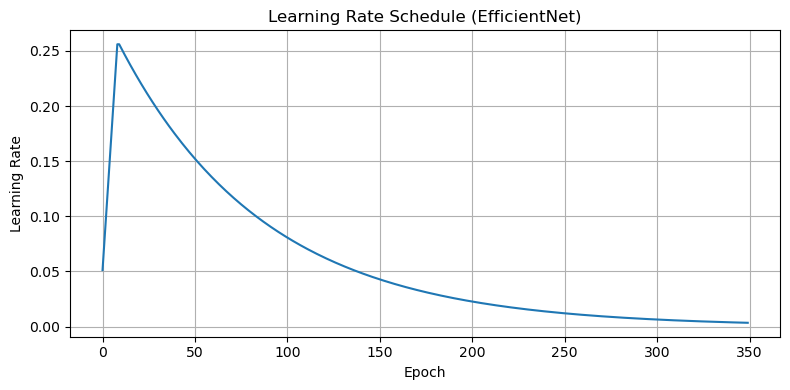

In [10]:
# ------------------------------------------------------------------ #
# 3. Quick Demo: Simulate Learning Rate Decay                        #
# ------------------------------------------------------------------ #
# This cell simulates the learning rate decay schedule and plots it.

import matplotlib.pyplot as plt

# Recreate scheduler for full LR curve
net, _ = efficientnet("b0", num_classes=10)
opt = RMSprop(net.parameters(), lr=paper_lr(batch),
              alpha=0.9, momentum=0.9, eps=0.1, weight_decay=1e-5)

# Define the learning rate decay schedule
def lr_lambda(epoch):
    """
    Define the learning rate decay schedule.
    
    Args:
        epoch (int): Current epoch number.
    
    Returns:
        float: The learning rate factor for the given epoch.
    """
    if epoch < 10:
        return (epoch + 1) / 10  # Warm-up for the first 10 epochs
    return 0.97 ** ((epoch - 10) / 2.4)  # Exponential decay after 10 epochs


sch = LambdaLR(opt, lr_lambda, last_epoch=-1)
init_lr = paper_lr(batch)

# Collect LR values
lr_values = []
for epoch in range(350):
    sch.step()
    lr_values.append(sch.get_last_lr()[0])

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(350), lr_values)
plt.title("Learning Rate Schedule (EfficientNet)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


# 🟢 Training & Evaluation Helpers (AMP + EMA)

This cell provides essential helper functions for training and evaluating EfficientNet models with PyTorch, utilizing Automatic Mixed Precision (AMP) and Exponential Moving Average (EMA) for optimized training and improved generalization.

### Key Components:

#### 1. `MetricTracker`
- Tracks and computes running averages of metrics such as loss and accuracy during training and evaluation.

#### 2. `accuracy(output, target, topk=(1,))`
- Computes **Top-1** and **Top-5** accuracy by comparing model predictions to the target labels.

#### 3. `train_one_epoch(model, ema, loader, optimizer, scaler, device, epoch, print_every=100)`
- **Trains** the model for one epoch using **AMP** for faster training and lower memory usage.
- Applies **label smoothing** (`0.1`) to the cross-entropy loss for improved regularization.
- Logs the **average training loss** every `print_every` steps.
- Optionally updates the **EMA** of the model's parameters to improve generalization.

#### 4. `evaluate(model, loader, device)`
- **Evaluates** the model’s performance on the validation dataset.
- Computes and returns the **loss**, **Top-1 accuracy**, and **Top-5 accuracy**.

### Expected Output:

- **Training Loss**: The loss value logged during training for each epoch.
- **Top-1 Accuracy**: The percentage of correct predictions in the top-1 position.
- **Top-5 Accuracy**: The percentage of correct predictions in the top-5 positions.

In [11]:
# 🟢 Cell 6a — Metric Tracking, Accuracy, and Evaluation Helpers

import torch
from torch.amp import GradScaler, autocast
import torch.nn.functional as F
from collections import defaultdict

class MetricTracker:
    def __init__(self):
        self.tot = defaultdict(float); self.n = defaultdict(int)
    def update(self, name, val, count=1):
        self.tot[name] += val * count
        self.n[name]   += count
    def avg(self, name):
        return self.tot[name] / max(1, self.n[name])

@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    _, pred = output.topk(maxk, 1, True, True)   # (B, maxk)
    pred = pred.t()                              # (maxk, B)
    correct = pred.eq(target.view(1, -1))
    res = []
    for k in topk:
        res.append(correct[:k].reshape(-1).float().sum().item())
    return res  # list of counts

# ------------------------------------------------------------------ #
# evaluation                                                         #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_correct1 = 0
    total_correct5 = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = F.cross_entropy(out, y, label_smoothing=0.0)

        # accumulate loss
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_samples += bs

        # top-k computation
        _, preds = out.topk(5, dim=1, largest=True, sorted=True)
        correct = preds.eq(y.view(-1,1))
        total_correct1 += correct[:, :1].sum().item()
        total_correct5 += correct.sum().item()

    avg_loss = total_loss / total_samples
    top1 = total_correct1 / total_samples * 100
    top5 = total_correct5 / total_samples * 100
    return avg_loss, top1, top5


In [12]:
# 🟢 Cell 6b — Train One Epoch Helper (with AMP)

def train_one_epoch(model, ema, loader, optimizer, scaler, device, epoch, print_every=100):
    """
    Trains the model for one epoch using AMP for faster training and reduced memory usage.

    Parameters:
    - model: The neural network model to be trained.
    - ema: Exponential Moving Average (EMA) object for smoothing model weights.
    - loader: DataLoader for loading the training data.
    - optimizer: Optimizer for model updates.
    - scaler: GradScaler for mixed-precision training.
    - device: Device (CPU or GPU) for model training.
    - epoch: Current epoch number.
    - print_every (optional): Frequency of logging during training (default 100).

    Returns:
    - None: Logs loss periodically during training.

    Notes:
    - Uses **AMP** to accelerate training and reduce memory usage.
    - Applies **label smoothing** (`0.1`) for better regularization.
    - Optionally updates model parameters with **EMA** for improved generalization.
    """
    model.train()
    mt = MetricTracker()
    for step, (x, y) in enumerate(loader, 1):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast("cuda"):  # Using mixed-precision
            out = model(x)
            loss = F.cross_entropy(out, y, label_smoothing=0.1)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        mt.update("loss", loss.item(), x.size(0))
        if step % print_every == 0 or step == len(loader):
            print(f"Epoch {epoch:03d} [{step:4d}/{len(loader)}] "
                  f"loss {mt.avg('loss'):.3f}")



# 🟢 Full Experiment Driver (Training Loop + Logging + Checkpoints)

This cell defines and runs the full training pipeline for EfficientNet on CIFAR-10 or ImageNet.

### Key Features:

- **Model & Data Setup**:
  - Builds compound-scaled EfficientNet model and dataloaders.
  - Supports both CIFAR-10 (`imagenet=False`) and full ImageNet.
- **Optimizer, LR Scheduler, EMA**:
  - Uses RMSProp, LR warm-up + exponential decay, and EMA smoothing.
- **TensorBoard Logging**:
  - Logs validation loss, Top-1/Top-5 accuracy, and learning rate.
- **Checkpoint Saving**:
  - Saves model and EMA weights every `save_every` epochs.
  - Saved to a `checkpoints/` directory for reuse or Grad-CAM.

### Usage:

The function `run_experiment(...)` handles everything:
- Just specify the `version` (`b0–b7`), number of `epochs`, and `batch` size.
- A quick smoke test is run for 5 epochs on CIFAR-10.

> The best Top-1 accuracy is tracked and printed at the end of training.


In [13]:
# 🟢 Cell 7 — full experiment driver

import os, time, torch
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"

def run_experiment(version="b0",
                   epochs=35,
                   batch=128,
                   imagenet=False,
                   save_every=5,
                   work_dir="checkpoints", depth_only=False, width_only=False, res_only=False):

    # --- build model & data -------------------------------------------------
    phi = int(version[1])
    if version == "b0": 
        if depth_only: ## b0 (depth scaling only)
            d_mult = 4.0
            model, img_res = efficientnet(
                version=version,
                depth_mult=d_mult,
                width_mult=1.0,
                resolution_mult=1.0,
                drop_rate=VER_CFG[version]["drop"],
                dropconnect_rate=VER_CFG[version]["dropconnect"]
            )
        elif width_only: ## b0 (width scaling only)
            w_mult = 2.0
            model, img_res = efficientnet(
                version=version,
                depth_mult=1.0,
                width_mult=w_mult,
                resolution_mult=1.0,
                drop_rate=VER_CFG[version]["drop"],
                dropconnect_rate=VER_CFG[version]["dropconnect"]
            )
        elif res_only: ## b0 (resolution scaling only)
            res_mult = 2.0
            model, img_res = efficientnet(
                version=version,
                depth_mult=1.0,
                width_mult=1.0,
                resolution_mult=res_mult,
                drop_rate=VER_CFG[version]["drop"],
                dropconnect_rate=VER_CFG[version]["dropconnect"]
            )
        else: ## b0 (baseline)
            model, img_res = efficientnet(
                version=version,
                depth_mult=1.0,
                width_mult=1.0,
                resolution_mult=1.0,
                drop_rate=VER_CFG[version]["drop"],
                dropconnect_rate=VER_CFG[version]["dropconnect"]
            )
    else: ##  (compound scaling)
        model, img_res = efficientnet(
                version=version,
                drop_rate=VER_CFG[version]["drop"],
                dropconnect_rate=VER_CFG[version]["dropconnect"]
            )
        
    model.to(device)
    train_loader, val_loader = get_dataloaders(batch, img_res, imagenet)
    global_batch = batch * torch.cuda.device_count()

    # --- optimiser / scheduler / EMA ---------------------------------------
    optimizer, scheduler, ema, init_lr = build_optimizer_scheduler(
        model, global_batch, epochs)
    scaler = GradScaler()

    # --- logging ------------------------------------------------------------
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    if depth_only:
        tag = f"{version}_depthonly"
    elif width_only:
        tag = f"{version}_widthonly"
    elif res_only:
        tag = f"{version}_resonly"
    else:
        tag = version

    writer = SummaryWriter(log_dir=f"runs/{tag}_{stamp}")
    os.makedirs(work_dir, exist_ok=True)

    best_acc = 0
    for epoch in range(epochs):
        print(f"\n===== Epoch {epoch:03d}/{epochs-1}  LR {scheduler.get_last_lr()[0]:.4e} =====")
        train_one_epoch(model, ema, train_loader, optimizer, scaler, device, epoch)

        val_loss, val_top1, val_top5 = evaluate(model, val_loader, device)
        writer.add_scalar("val/loss",  val_loss,  epoch)
        writer.add_scalar("val/top1",  val_top1,  epoch)
        writer.add_scalar("val/top5",  val_top5,  epoch)
        writer.add_scalar("lr",        scheduler.get_last_lr()[0], epoch)

        print(f"★ Val loss {val_loss:.3f} | Top-1 {val_top1:.2f}% | Top-5 {val_top5:.2f}%")
        best_acc = max(best_acc, val_top1)

        scheduler.step()

        if (epoch + 1) % save_every == 0 or epoch == epochs - 1:
            ckpt_path = f"{work_dir}/eff_{tag}_ep{epoch+1}_v2.pt"
            torch.save({"model": model.state_dict(),
                        "ema":   ema.module.state_dict(),
                        "epoch": epoch}, ckpt_path)
            print("💾 Saved", ckpt_path)

    writer.flush(); writer.close()
    print(f"\nFinished: best Top-1 = {best_acc:.2f}%")

# ── quick smoke invocation (CIFAR-10, 5 epochs) ────────────────────────────
#run_experiment(version="b0", epochs=5, batch=128, imagenet=False)

### 🟢 Baseline: EfficientNet B0–B7 without Compound Scaling on CIFAR-10

This cell runs baseline experiments using EfficientNet models **without compound scaling**—keeping width, depth, and resolution multipliers all set to `1.0`. Models are trained on CIFAR-10, and performance is evaluated in terms of parameter count vs. Top-1 accuracy.

### Setup:
- **Scaling**: `depth_mult=1.0`, `width_mult=1.0`, `resolution_mult=1.0` (no scaling)
- **Dataset**: CIFAR-10 (`num_classes=10`)
- **Output**: Scatter plot of model size vs. validation accuracy



>>> Training B0 on CIFAR-10


c:\Users\LabUser\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


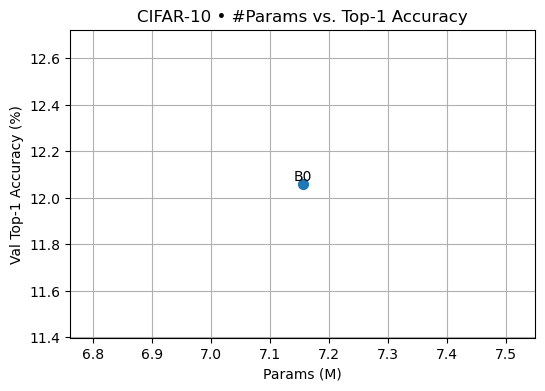

In [14]:
#Generating B0 without compound scaling (baseline)

import torch
import matplotlib.pyplot as plt

# 1) Versions to sweep
VERSIONS = [f"b{i}" for i in [0]]  # b0, b4, b7

results = []
for ver in VERSIONS:
    print(f"\n>>> Training {ver.upper()} on CIFAR-10")
    # run_experiment(version=ver, epochs=35, batch=128, imagenet=False)

    # 2) Load the final checkpoint’s raw model weights
    ckpt = torch.load(f"checkpoints/eff_{ver}_ep35_v2.pt", map_location="cpu")
    model, _ = efficientnet(version=ver,
                            depth_mult=1.0,
                            width_mult=1.0,
                            resolution_mult=1.0,
                            drop_rate=VER_CFG[ver]["drop"],
                            dropconnect_rate=VER_CFG[ver]["dropconnect"],
                            num_classes=10)
    model.load_state_dict(ckpt["model"])
    model.eval()

    # 3) Evaluate on the full val set
    _, val_loader = get_dataloaders(batch=128, img_res=32, imagenet=False)
    acc_total = 0
    n = 0
    with torch.no_grad():
        for x,y in val_loader:
            out = model(x)
            preds = out.argmax(1)
            acc_total += (preds == y).sum().item()
            n += y.size(0)
    top1 = acc_total / n * 100

    # 4) Count parameters
    params = sum(p.numel() for p in model.parameters()) / 1e6

    results.append((ver.upper(), params, top1))

# 5) Plot
versions, params, accs = zip(*results)
plt.figure(figsize=(6,4))
plt.scatter(params, accs, s=50)
for v,p,a in results:
    plt.text(p, a, v, ha="center", va="bottom")
plt.title("CIFAR-10 • #Params vs. Top-1 Accuracy")
plt.xlabel("Params (M)")
plt.ylabel("Val Top-1 Accuracy (%)")
plt.grid(True)
plt.show()

### 🟢 Depth-Only Scaling: EfficientNet B0–B7 on CIFAR-10

This cell evaluates the effect of **depth-only scaling** on EfficientNet models by increasing the network depth (`depth_mult=4.0`) while keeping width and resolution fixed. Models are trained on CIFAR-10, and the relationship between model size and accuracy is visualized.

### Setup:
- **Scaling**: `depth_mult=4.0`, `width_mult=1.0`, `resolution_mult=1.0`
- **Dataset**: CIFAR-10 (`num_classes=10`)
- **Output**: Scatter plot of parameter count vs. validation Top-1 accuracy


In [15]:
import torch
import matplotlib.pyplot as plt

VERSIONS = [f"b{i}" for i in [0]]
results = []

for ver in VERSIONS:
    print(f"\n>>> Training {ver.upper()} with DEPTH-ONLY on CIFAR-10")
    run_experiment(version=ver, epochs=35, batch=128, imagenet=False,
                   save_every=5, work_dir="checkpoints",
                   depth_only=True, width_only=False, res_only=False)

    ckpt_path = f"checkpoints/eff_{ver}_depthonly_ep35_v2.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model, _ = efficientnet(version=ver,
                            depth_mult=4.0,
                            width_mult=1.0,
                            resolution_mult=1.0,
                            drop_rate=VER_CFG[ver]["drop"],
                            dropconnect_rate=VER_CFG[ver]["dropconnect"],
                            num_classes=10)
    model.load_state_dict(ckpt["model"])
    model.eval()

    _, val_loader = get_dataloaders(batch=128, img_res=32, imagenet=False)
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    top1 = correct / total * 100

    params = sum(p.numel() for p in model.parameters()) / 1e6
    results.append((ver.upper(), params, top1))

# Plot
versions, params, accs = zip(*results)
plt.figure(figsize=(6, 4))
plt.scatter(params, accs, s=50)
for v, p, a in results:
    plt.text(p, a, v, ha="center", va="bottom")
plt.title("CIFAR-10 • Depth-Only Scaling: #Params vs. Top-1 Accuracy")
plt.xlabel("Params (M)")
plt.ylabel("Val Top-1 Accuracy (%)")
plt.grid(True)
plt.show()



>>> Training B0 with DEPTH-ONLY on CIFAR-10


c:\Users\LabUser\anaconda3\lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



===== Epoch 000/34  LR 0.0000e+00 =====


c:\Users\LabUser\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 

### 🟢 Width-Only Scaling: EfficientNet B0–B7 on CIFAR-10

This cell trains and evaluates EfficientNet models using **width scaling only**, keeping depth and resolution constant. It loads checkpoints for each version (e.g., B0) trained on CIFAR-10, computes Top-1 accuracy, and visualizes model size vs. performance.

### Setup:
- **Scaling**: `width_mult=2.0`, `depth_mult=1.0`, `resolution_mult=1.0`
- **Dataset**: CIFAR-10 (`num_classes=10`)
- **Output**: Scatter plot of parameter count vs. validation accuracy



>>> Training B0 with WIDTH-ONLY on CIFAR-10


C:\Users\LabUser\AppData\Local\Temp\ipykernel_7988\3708577656.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


Files already downloaded and verified
Files already downloaded and verified


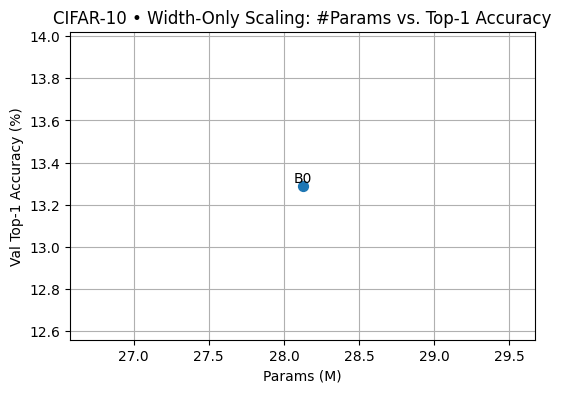

In [ ]:
import torch
import matplotlib.pyplot as plt

VERSIONS = [f"b{i}" for i in [0]]  # Extend to [0,1,...,7] for full sweep
results = []

for ver in VERSIONS:
    print(f"\n>>> Training {ver.upper()} with WIDTH-ONLY on CIFAR-10")
    # run_experiment(version=ver, epochs=35, batch=128, imagenet=False,
    #                save_every=5, work_dir="checkpoints",
    #                depth_only=False, width_only=True, res_only=False)

    # Load trained model
    ckpt_path = f"checkpoints/eff_{ver}_widthonly_ep35_v2.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model, _ = efficientnet(version=ver,
                            depth_mult=1.0,
                            width_mult=2.0,
                            resolution_mult=1.0,
                            drop_rate=VER_CFG[ver]["drop"],
                            dropconnect_rate=VER_CFG[ver]["dropconnect"],
                            num_classes=10)
    model.load_state_dict(ckpt["model"])
    model.eval()

    # Evaluate
    _, val_loader = get_dataloaders(batch=128, img_res=32, imagenet=False)
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    top1 = correct / total * 100

    # Count parameters
    params = sum(p.numel() for p in model.parameters()) / 1e6
    results.append((ver.upper(), params, top1))

# Plot
versions, params, accs = zip(*results)
plt.figure(figsize=(6, 4))
plt.scatter(params, accs, s=50)
for v, p, a in results:
    plt.text(p, a, v, ha="center", va="bottom")
plt.title("CIFAR-10 • Width-Only Scaling: #Params vs. Top-1 Accuracy")
plt.xlabel("Params (M)")
plt.ylabel("Val Top-1 Accuracy (%)")
plt.grid(True)
plt.show()


### 🟢 Resolution-Only Scaling: EfficientNet B0–B7 on CIFAR-10

This cell evaluates EfficientNet models using **resolution-only scaling**, where input resolution is increased (`resolution_mult=2.0`) while keeping depth and width fixed. Each model is trained on CIFAR-10, and performance is compared by plotting parameter count against Top-1 accuracy.

### Setup:
- **Scaling**: `resolution_mult=2.0`, `depth_mult=1.0`, `width_mult=1.0`
- **Dataset**: CIFAR-10 (`num_classes=10`)
- **Output**: Scatter plot of model size vs. validation accuracy



>>> Training B0 with RESOLUTION-ONLY on CIFAR-10


C:\Users\LabUser\AppData\Local\Temp\ipykernel_7988\1126035594.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


Files already downloaded and verified
Files already downloaded and verified


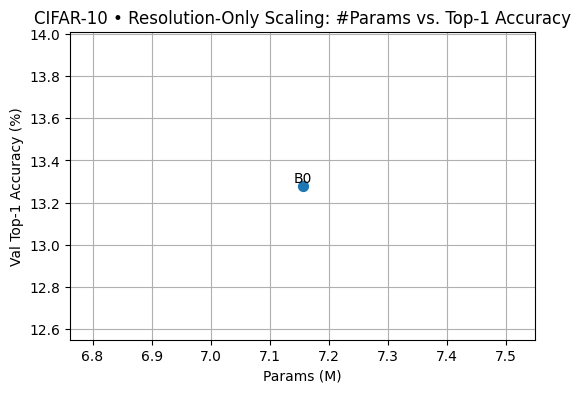

In [ ]:
import torch
import matplotlib.pyplot as plt

VERSIONS = [f"b{i}" for i in [0]]
results = []

for ver in VERSIONS:
    print(f"\n>>> Training {ver.upper()} with RESOLUTION-ONLY on CIFAR-10")
    # run_experiment(version=ver, epochs=35, batch=128, imagenet=False,
    #                save_every=5, work_dir="checkpoints",
    #                depth_only=False, width_only=False, res_only=True)

    ckpt_path = f"checkpoints/eff_{ver}_resonly_ep35_v2.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model, _ = efficientnet(version=ver,
                            depth_mult=1.0,
                            width_mult=1.0,
                            resolution_mult=2.0,
                            drop_rate=VER_CFG[ver]["drop"],
                            dropconnect_rate=VER_CFG[ver]["dropconnect"],
                            num_classes=10)
    model.load_state_dict(ckpt["model"])
    model.eval()

    _, val_loader = get_dataloaders(batch=128, img_res=32, imagenet=False)
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    top1 = correct / total * 100

    params = sum(p.numel() for p in model.parameters()) / 1e6
    results.append((ver.upper(), params, top1))

# Plot
versions, params, accs = zip(*results)
plt.figure(figsize=(6, 4))
plt.scatter(params, accs, s=50)
for v, p, a in results:
    plt.text(p, a, v, ha="center", va="bottom")
plt.title("CIFAR-10 • Resolution-Only Scaling: #Params vs. Top-1 Accuracy")
plt.xlabel("Params (M)")
plt.ylabel("Val Top-1 Accuracy (%)")
plt.grid(True)
plt.show()


>>> Training B2 (COMPOUND SCALING) on CIFAR-10


C:\Users\LabUser\AppData\Local\Temp\ipykernel_7988\3735798168.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


Files already downloaded and verified
Files already downloaded and verified


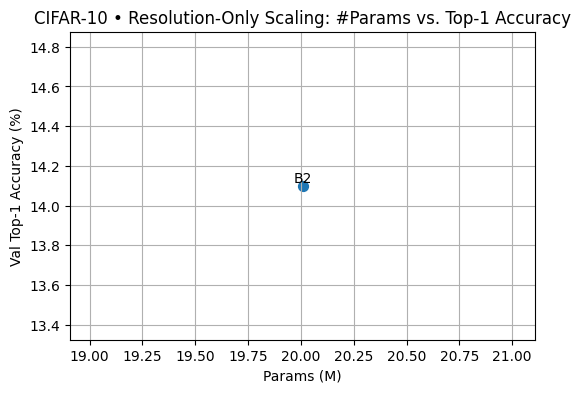

In [ ]:
import torch
import matplotlib.pyplot as plt

VERSIONS = [f"b{i}" for i in [2]]
results = []

for ver in VERSIONS:
    print(f"\n>>> Training {ver.upper()} (COMPOUND SCALING) on CIFAR-10")
    # run_experiment(version=ver, epochs=35, batch=128, imagenet=False,
    #                save_every=5, work_dir="checkpoints",
    #                depth_only=False, width_only=False, res_only=False)

    ckpt_path = f"checkpoints/eff_{ver}_ep35_v2.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model, _ = efficientnet(
        version=ver,
        num_classes=10,
        depth_mult=1.44,
        width_mult=1.2,
        resolution_mult=1.3225,
        drop_rate=VER_CFG[ver]["drop"],
        dropconnect_rate=VER_CFG[ver]["dropconnect"]
    )

    model.load_state_dict(ckpt["model"])
    model.eval()


    _, val_loader = get_dataloaders(batch=128, img_res=32, imagenet=False)
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    top1 = correct / total * 100

    params = sum(p.numel() for p in model.parameters()) / 1e6
    results.append((ver.upper(), params, top1))

# Plot
versions, params, accs = zip(*results)
plt.figure(figsize=(6, 4))
plt.scatter(params, accs, s=50)
for v, p, a in results:
    plt.text(p, a, v, ha="center", va="bottom")
plt.title("CIFAR-10 • Resolution-Only Scaling: #Params vs. Top-1 Accuracy")
plt.xlabel("Params (M)")
plt.ylabel("Val Top-1 Accuracy (%)")
plt.grid(True)
plt.show()


# 🟢 Grad-CAM Visualization & Run Summary (Post-training Analysis)

This cell visualizes model attention using Grad-CAM and summarizes training runs.

### Grad-CAM Visualization:
- Loads the **latest checkpoint** (from `checkpoints/`).
- Uses **EMA weights** for cleaner, smoothed activations.
- Applies **Grad-CAM** to the last `ConvBNAct` layer before pooling.
- Overlays the activation heatmap on the original RGB image.

### Run Summary Table:
- Reads all TensorBoard logs under `runs/`.
- Extracts:
  - Version (`B0–B7`)
  - Number of epochs
  - Best Top-1 accuracy and the epoch it occurred
- Displays results in a table and validation accuracy plot.

C:\Users\LabUser\AppData\Local\Temp\ipykernel_7988\496808120.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


Files already downloaded and verified
Files already downloaded and verified


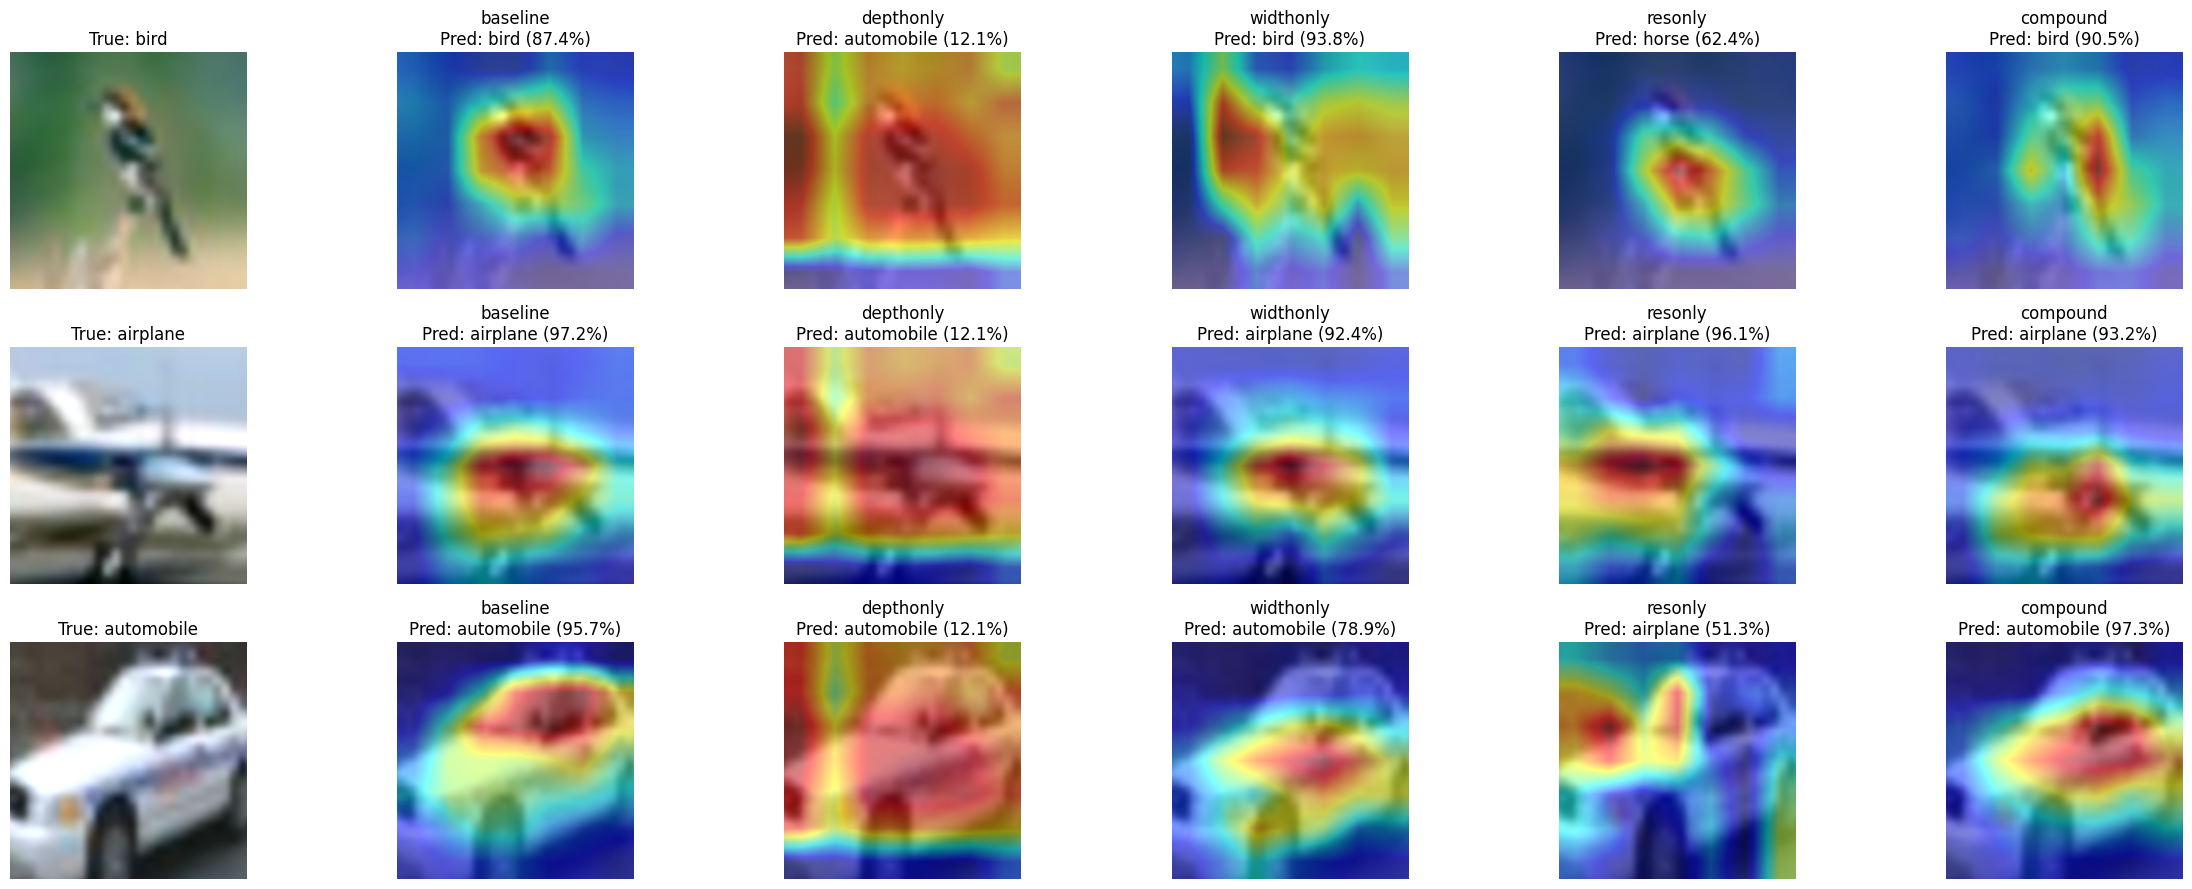

In [ ]:
import matplotlib.pyplot as plt
import numpy as np, torch
from pathlib import Path
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# CIFAR-10 class names
CIFAR10_CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Versions and modes
ver = "b0"
compound_ver = "b2"
modes = ["baseline", "depthonly", "widthonly", "resonly", "compound"]

# Load all 5 models
models = {}
img_res_map = {}

for mode in modes:
    if mode == "baseline":
        ckpt_path = f"checkpoints/eff_{ver}_ep35_v2.pt"
        model, img_res = efficientnet(
            ver, num_classes=10,
            depth_mult=1.0,
            width_mult=1.0,
            resolution_mult=1.0,
            drop_rate=VER_CFG[ver]["drop"],
            dropconnect_rate=VER_CFG[ver]["dropconnect"]
        )

    elif mode == "depthonly":
        ckpt_path = f"checkpoints/eff_{ver}_depthonly_ep35_v2.pt"
        model, img_res = efficientnet(
            ver, num_classes=10,
            depth_mult=4.0,
            width_mult=1.0,
            resolution_mult=1.0,
            drop_rate=VER_CFG[ver]["drop"],
            dropconnect_rate=VER_CFG[ver]["dropconnect"]
        )

    elif mode == "widthonly":
        ckpt_path = f"checkpoints/eff_{ver}_widthonly_ep35_v2.pt"
        model, img_res = efficientnet(
            ver, num_classes=10,
            depth_mult=1.0,
            width_mult=2.0,
            resolution_mult=1.0,
            drop_rate=VER_CFG[ver]["drop"],
            dropconnect_rate=VER_CFG[ver]["dropconnect"]
        )

    elif mode == "resonly":
        ckpt_path = f"checkpoints/eff_{ver}_resonly_ep35_v2.pt"
        model, img_res = efficientnet(
            ver, num_classes=10,
            depth_mult=1.0,
            width_mult=1.0,
            resolution_mult=2.0,
            drop_rate=VER_CFG[ver]["drop"],
            dropconnect_rate=VER_CFG[ver]["dropconnect"]
        )

    elif mode == "compound":
        ckpt_path = f"checkpoints/eff_{compound_ver}_ep35_v2.pt"
        model, _ = efficientnet(
            version=ver,
            num_classes=10,
            depth_mult=1.44,
            width_mult=1.2,
            resolution_mult=1.3225,
            drop_rate=VER_CFG[ver]["drop"],
            dropconnect_rate=VER_CFG[ver]["dropconnect"]
        )

    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state["model"])
    model.to(device).eval()
    models[mode] = model
    img_res_map[mode] = img_res

# Use smallest img_res to avoid upscaling too much
img_res = min(img_res_map.values())

# Build val_loader
_, base_val_loader = get_dataloaders(batch=1, img_res=img_res, imagenet=False)
val_loader = DataLoader(base_val_loader.dataset,
                        batch_size=1,
                        shuffle=True,
                        num_workers=2,
                        pin_memory=True)

# CIFAR normalization stats (for undoing)
MEAN = np.array([0.4914, 0.4822, 0.4465])
STD  = np.array([0.2470, 0.2435, 0.2616])

# Sample and plot
N_SAMPLES = 3
fig, axes = plt.subplots(N_SAMPLES, len(modes) + 1, figsize=(4*(len(modes)+1), 3*N_SAMPLES))
it = iter(val_loader)

for i in range(N_SAMPLES):
    img_tensor, label = next(it)
    img_tensor = img_tensor.to(device)
    true_label = label.item()

    # Undo normalization
    rgb = img_tensor[0].cpu().permute(1, 2, 0).numpy()
    rgb = np.clip((rgb * STD) + MEAN, 0, 1)

    # Column 0: original image
    axes[i, 0].imshow(rgb)
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"True: {CIFAR10_CLASSES[true_label]}")

    # Columns 1+: Grad-CAM overlays
    for j, mode in enumerate(modes):
        model = models[mode]
        cam = GradCAM(model=model, target_layers=[model[-5][0]])

        with torch.no_grad():
            logits = model(img_tensor)
            probs = torch.softmax(logits, dim=1)[0]
            pred_idx = int(probs.argmax())
            pred_conf = float(probs[pred_idx]) * 100

        grayscale_cam = cam(img_tensor)[0]
        overlay = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

        axes[i, j + 1].imshow(overlay)
        axes[i, j + 1].axis("off")
        axes[i, j + 1].set_title(
            f"{mode}\nPred: {CIFAR10_CLASSES[pred_idx]} ({pred_conf:.1f}%)"
        )

plt.tight_layout()
plt.show()





C:\Users\LabUser\AppData\Local\Temp\ipykernel_7988\1689629374.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

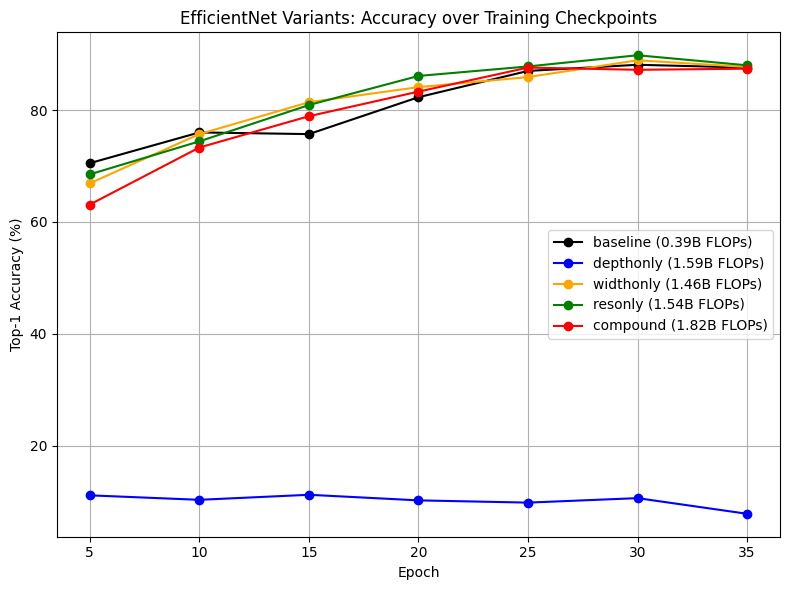

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data import Subset, DataLoader
import gc

# 1) Utility to estimate FLOPs
def estimate_flops(model, img_res=224):
    macs = defaultdict(int)
    def conv_hook(mod, inp, outp):
        Cin, Cout = mod.in_channels, mod.out_channels
        Hout, Wout = outp.shape[2:]
        kH, kW = mod.kernel_size
        groups = mod.groups
        macs['conv'] += Cout * Cin / groups * kH * kW * Hout * Wout
    def linear_hook(mod, inp, outp):
        macs['fc'] += mod.in_features * mod.out_features
    hooks = []
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            hooks.append(m.register_forward_hook(conv_hook))
        elif isinstance(m, nn.Linear):
            hooks.append(m.register_forward_hook(linear_hook))
    model.eval()
    with torch.no_grad():
        dummy = torch.zeros(1, 3, img_res, img_res)
        model(dummy)
    for h in hooks:
        h.remove()
    return sum(macs.values()) / 1e9  # GFLOPs

# 2) Define configurations
scaling_configs = {
    "baseline": ("b0", 1.0, 1.0, 1.0),
    "depthonly": ("b0", 4.0, 1.0, 1.0),
    "widthonly": ("b0", 1.0, 2.0, 1.0),
    "resonly": ("b0", 1.0, 1.0, 2.0),
    "compound": ("b2", 1.44, 1.2, 1.3225)
}
checkpoints = [5, 10, 15, 20, 25, 30, 35]

# 3) Precompute FLOPs per model
flops_dict = {}
for mode, (ver, d, w, r) in scaling_configs.items():
    model, img_res = efficientnet(
        version=ver,
        num_classes=10,
        depth_mult=d, width_mult=w, resolution_mult=r,
        drop_rate=VER_CFG[ver]["drop"],
        dropconnect_rate=VER_CFG[ver]["dropconnect"]
    )
    flops_dict[mode] = estimate_flops(model, img_res)
    del model
    gc.collect()

# 4) Prepare a small validation subset loader for speed
def get_fast_loader(img_res, batch=64, subset_size=1000):
    _, full_loader = get_dataloaders(batch=batch, img_res=img_res, imagenet=False)
    ds = full_loader.dataset
    subset = Subset(ds, list(range(min(len(ds), subset_size))))
    return DataLoader(subset, batch_size=batch, shuffle=False)

# 5) Collect Top-1 accuracies per epoch
acc_dict = {mode: [] for mode in scaling_configs}
for mode, (ver, d, w, r) in scaling_configs.items():
    print(f"Collecting accuracies for {mode}...")
    for ep in checkpoints:
        # construct checkpoint path
        if mode == "baseline":
            ckpt_path = f"checkpoints/eff_b0_ep{ep}_v2.pt"
        elif mode == "compound":
            ckpt_path = f"checkpoints/eff_b2_ep{ep}_v2.pt"
        else:
            ckpt_path = f"checkpoints/eff_b0_{mode}_ep{ep}_v2.pt"
        ckpt = torch.load(ckpt_path, map_location="cpu")

        model, img_res = efficientnet(
            version=ver,
            num_classes=10,
            depth_mult=d, width_mult=w, resolution_mult=r,
            drop_rate=VER_CFG[ver]["drop"], dropconnect_rate=VER_CFG[ver]["dropconnect"]
        )
        model.load_state_dict(ckpt["model"])
        model.eval()

        # fast loader
        val_loader = get_fast_loader(img_res)

        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                preds = model(x).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        acc = correct / total * 100
        acc_dict[mode].append(acc)

        del model
        gc.collect()
        torch.cuda.empty_cache()

# 6) Plot Top-1 vs Epoch for each model
plt.figure(figsize=(8, 6))
colors = {
    "baseline": "black", "depthonly": "blue",
    "widthonly": "orange", "resonly": "green",
    "compound": "red"
}
for mode in scaling_configs:
    plt.plot(checkpoints, acc_dict[mode], label=f"{mode} ({flops_dict[mode]:.2f}B FLOPs)",
             color=colors[mode], marker='o')
plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("EfficientNet Variants: Accuracy over Training Checkpoints")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

